<a href="https://colab.research.google.com/github/Joako360/Speaker-Recognition-Notebook/blob/main/formant_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io.wavfile import read, write #Audio y read son utilizados para archivos de audio
from IPython.display import Audio


In [ ]:
def plot_sample(signals, sr, ax=None, plot_type=None, labels=None):
  """
  Grafica una señal de audio en el tiempo.

  Parámetros:
  s (ndarray): Señal de audio.
  sr (int): Frecuencia de muestreo de la señal de audio.
  """

  if type(signals) != list:
    signals = [signals]
  if type(plot_type) != list:
    plot_type = [plot_type] * len(signals)
  duration = len(signals[0]) / sr
  t = np.linspace(0, duration, num=len(signals[0]))
  if ax is None:
    fig, ax = plt.subplots()
  for i, s in enumerate(signals):
    if labels is not None:
      label = labels[i]
    else:
      label = None
    if plot_type[i] == 'stem':
      ax.stem(t, s, linefmt=f'C{i}-', markerfmt=f'C{i}_', label=label)
    elif plot_type[i] == 'step':
      ax.step(t,s, where='post', color=f'C{i}', label=label)
    else:
      ax.plot(t,s, color=f'C{i}', label=label)
  ax.set_xlabel('Tiempo [s]'); ax.set_ylabel('Amplitud')
  if labels is not None:
    ax.legend()
  ax.grid(True)
  plt.show()
  return ax


In [ ]:
def plot_fft(s, sr, ax=None, dtype=None):
  """
  Plot the FFT of an audio signal.

  Parameters
  ----------
  s : ndarray
      Audio signal.
  sr : int
      Sampling rate of the audio signal.
  """

  N =s.size
  if dtype == 'freq':
    S = s
    freq = np.linspace(0,sr/2,N)
  elif dtype == 'time' or dtype == None:
    S = np.abs(np.fft.rfft(s)/np.sqrt(N))
    freq = np.fft.rfftfreq(N, d=1/sr)
  else: return

  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(freq, S)
  ax.set_xlabel('Frecuencia [Hz]');ax.set_ylabel('Magnitud')
  ax.set_title('Audio Signal FFT')
  ax.grid(True)
  #plt.show()
  return ax


In [ ]:
def plot_freqz(b, a=1):
    w, h = signal.freqz(b, a)
    fig, ax1 = plt.subplots()
    ax1.set_title('Respuesta en frecuencia del filtro')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Magnitud [dB]', color='b')
    ax1.set_xlabel('Frecuencia [rad/muestra]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Fase [radianes]', color='g')
    ax1.grid(True, alpha=0.5)
    plt.show()

In [ ]:
def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    return plt.loglog(f, np.abs(np.fft.rfft(s)))[0]

In [ ]:
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

In [ ]:
def two_pole_res(fc, bw, fs):
  R = np.exp(-np.pi * bw / fs)
  G = 1 - R
  a1 = -2*R*np.cos(2*np.pi*(fc/fs))
  a2 = R*R
  a = np.array([1, a1, a2])
  b = np.array([1, 0, -R])
  b *= G
  return b, a



def butter_bandpass_filter(lowcut, highcut, sr, order=1):
    """
    Devuelve relultado de pasar señal o envolvente "s" por filtro pasa banda.

    Parameters
    ----------
    s : TYPE
        DESCRIPTION.
    lowcut : TYPE
        DESCRIPTION.
    highcut : TYPE
        DESCRIPTION.
    sr : TYPE
        DESCRIPTION.
    order : TYPE, optional
        DESCRIPTION. The default is 5.

    Returns
    -------
    y : TYPE
        DESCRIPTION.

    """
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

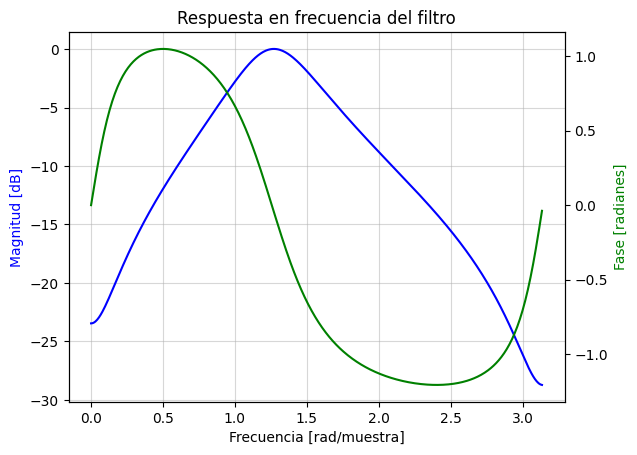

In [ ]:
b, a = two_pole_res(.2,.1,1)
plot_freqz(b,a)

In [ ]:
normalize = lambda s: s / np.max(np.abs(s)) # normalizar audio entre -1 y 1
    # dividir cada muestra del audio por la intensidad máxima


def blp(fs, n, N, amp, f0):
  t = np.linspace(0, n / fs, n)
  bn = pink_noise(n)
  y = np.zeros(n)
  for k in range(N-1):
    lowcut = f0*(k+1)-30; hicut= f0*(k+1)+30
    b, a = butter_bandpass_filter(lowcut,hicut,fs, order=3)
    bnf = signal.lfilter(b, a, bn)
    #y += np.sin(2*np.pi*k*f0*t)
    y += bnf
  y = normalize(y)*amp
  return y

In [ ]:
y=blp(8000,8000,13,1,300)
#b, a = two_pole_res(300,50,8000)
#y = signal.lfilter(b, a, y)
#y+=bn

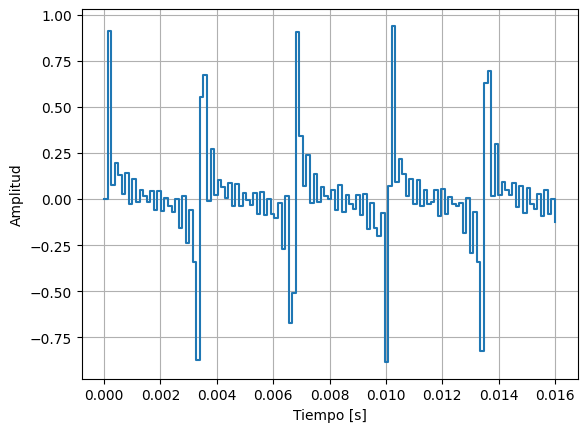

<Axes: title={'center': 'Audio Signal FFT'}, xlabel='Frecuencia [Hz]', ylabel='Magnitud'>

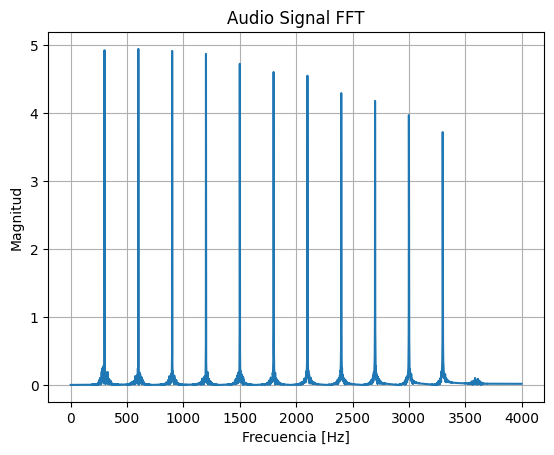

In [ ]:
plot_sample(y[:128],8000, plot_type='step')
plot_fft(y,8000)

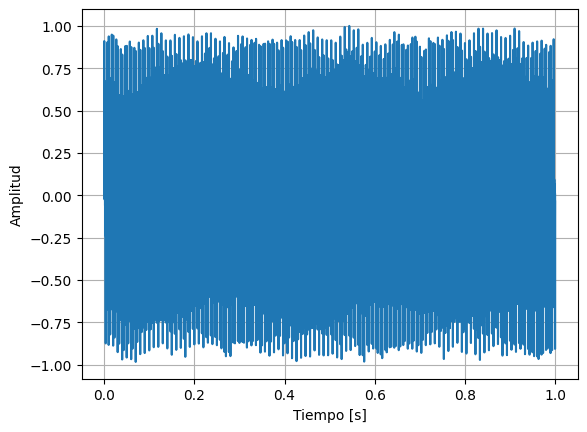

<Axes: title={'center': 'Audio Signal FFT'}, xlabel='Frecuencia [Hz]', ylabel='Magnitud'>

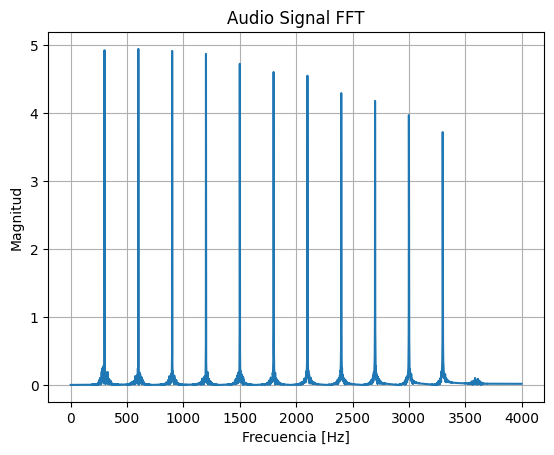

In [ ]:
plot_sample(y,8000, plot_type='step')
plot_fft(y,8000)

In [ ]:
Audio(y, rate=8000)

In [ ]:
Audio(bn, rate=8000)

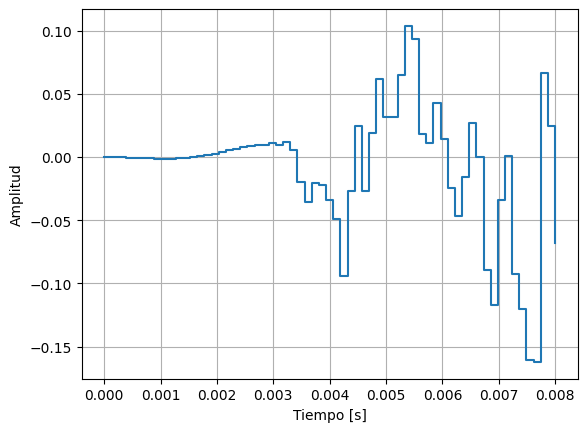

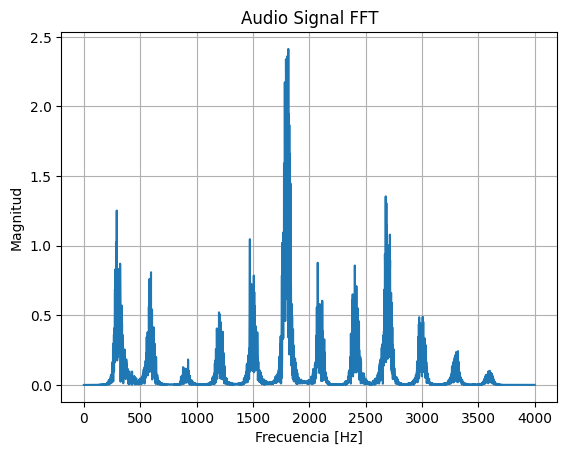

In [ ]:
F1=450
F2=1840
F3=2560
y=blp(8000,8000,13,1,300)
b1, a1 = two_pole_res(F1,50,8000)
y1 = signal.lfilter(b1, a1, y)
b2, a2 = two_pole_res(F2,180,8000)
y2 = signal.lfilter(b2, a2, y)
b3, a3 = two_pole_res(F3,140,8000)
y3 = signal.lfilter(b3, a3, y)
y = y1 + y2 + y3
y = normalize(y)
plot_sample(y[:64],8000, plot_type='step')
plot_fft(y,8000)
Audio(y, rate=8000)

In [ ]:
form={#Diccionario de frecuencias de formantes vocales
    'a':[(700, 60), (1500, 200), (2400, 100)],#'vocal':[(F1, sd1), (F2, sd2), (F3, sd3)]
    'e':[(540, 60), (1850, 50), (2540, 140)],#'vocal' es la clave de entrada y hace referencia a la vocal a formar
    'i':[(290, 30), (2200, 180), (2650, 200)],#FN es la frecuencia del formante primero, segundo o tercero
    'o':[(500, 20), (1000, 250), (2280, 100)],#sdN es el desvio que tiene y se usa como ancho de banda para el formante
    'u':[(330, 30), (930, 350), (2300, 100)],#para llamar: form['vocal'][N][F(0) o sd(1)]
}

In [ ]:
fs = 8000
t = np.linspace(0, 1, fs)

# la onda diente de sierra es mas rica en armonicos que otras formas de onda
saw = signal.sawtooth(2*np.pi*330*t,width=.8)
e=[]# esta es una lista donde almacenamos las tres formantes y luego lo sumamos
for i, formant in enumerate(form['e']):
  fc = form['e'][i][0]
  # Q es el factor de calidad es igual a fc/bw fc: frecuencia central, bw: ancho de banda
  Q = fc / form['e'][i][1]
  b, a = signal.iirpeak(fc, Q, fs)
  e.append(signal.lfilter(b, a, saw))
e=np.mean(e, axis=0)# en realidad lo promediamos para mantener la amplitud
e /= np.max(np.abs(e)) #deberia sonar como la vocal 'e'

In [ ]:
Audio(e, rate=8000)